# ADVANCED CHANGEPOINT DETECTION: ONLINE APPLICATION

Welcome to our series about *advanced changepoint detection*. In this series we want to explain special topics in the field of changepoint detection, sometimes also called changepoint analysis. 

An introduction to changepoint analysis can be found in our [introduction blog](./CP-detection1-intro.ipynb).

In this blog, we want to focus on an online algorithms to detect changes in mean.

Let's import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1) Create an example

Let's consider the following example. We define a signal with length $1200$ and two changepoints at $400$ and $900$.

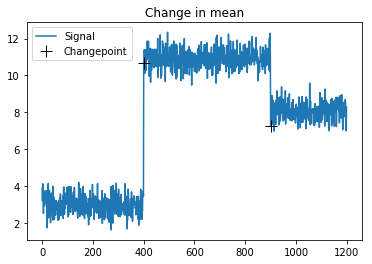

In [2]:
signal_length=1200
my_changepoints=[400,900]

np.random.seed(0)
signal = np.random.normal(3, 0.5, my_changepoints[0])
signal = np.append(signal,np.random.normal(11, 0.5, my_changepoints[1]-my_changepoints[0] ))
signal = np.append(signal,np.random.normal(8, 0.5, signal_length-my_changepoints[1] ))
_, ax1 = plt.subplots()
ax1.set_title('Change in mean')
ax1.plot(signal, label='Signal')
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12,label='Changepoint')
ax1.legend();

## 2) Description of the OFCD algorithm

The OFCD algorithm (OFCD=Online, adaptive Filtering-based Change Detection) is one of the fastest algoritms to detect a change in mean. Also, the basic idea of this method is quite intuitive and relativly easy to understand. A full description can be found in (Fathy et al., 2019)

Basically, it is a sliding window algorithm, but instead of using a single window it uses two windows, namely a short and a long window.

Let's consider the idea in an animation:

In [3]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src="./Images/demo-ofcd.mp4" type="video/mp4">
</video></div>

The animation shows that it is sufficient to compare the mean values of the two windows:

- as long as the signal is constant, both windows will have the same mean values
- the *slow* (long) window reaches the changepoint, before the other *fast* (short) window reaches the changepoint
- the mean of the slow window changes slowly, whereas the mean of the fast window stays constant
- hence, by comparing the two means of the two sliding windows a change in mean can be detected quite easily.

Now, the concept in (Fathy et al. 2019) becomes a little bit tricky:

- the algorithm treats the two means as a convex combination (i.e. each mean gets a non-negative weight and both weights sum up to 1)
- the weight for the fast window is a scalar $\lambda_\in [0,1]$, i.e. the slow window has weight $(1-\lambda)$
- at the beginning all weight is at the slow window, i.e. $\lambda=0$
- in some sense, $\lambda$ can be interpreted as a forgetting factor: if $\lambda$ is low (almost zero) we can ignore the fast window
- at each time step (data point), $\lambda$ gets updated
- the update can be regulized by a parameter $\alpha>0$ that can somehow be interpreted as a learning rate
- if $\lambda$ is large enough the datapoint is marked as a changepoint.
- the algorithm is arranged in a way that the change gets marked *after* the fast window passed the changepoint.

## 3) Code of the OFCD algorithm

We tried to follow the notation of the paper (Fathy et al. 2019) as close as possible.

The inputs of the algorithms are:

- X: the signal itself
- $\alpha$: learning rate
- $w_s$: size of the *slow window* (big window)
- $w_f$ size of the *fast window* (small window)
- $h$: threshold (usually, the smaller $h$ the faster a changepoint is detected and the more changepoints are detected)

In [4]:
X = signal.copy()
alpha = 0.1 # must be >0
w_s = 100 # window length
w_f = 10 # window length
h = 1 # threshold >0

Let's run the algorithm and plot the result:

In [5]:
# initialize lambda
my_lambda = 0.0
# initialize a boolean vector (for each datapoint)
tau = np.zeros(len(X),dtype=bool)

# procedure according to the pseudo code

# convolution done earler => skip first entries
t = w_s 
# convolution done earler => skip last entries
while t < X.shape[0]-w_s: 
    y_f = np.mean(X[t-w_f:t])
    y_s = np.mean(X[t - w_s:t])
    y = my_lambda*y_f + (1-my_lambda)*y_s # the convex combination
    e = X[t] - y # e like "error"
    my_lambda = my_lambda + alpha*e*(y_f-y_s)
    if my_lambda >= h: # mark detected change point, set my_lambda back to zero
        tau[t]=True
        my_lambda = 0
    #lambda must always stay in the interval [0,1]
    if my_lambda >1:
        my_lambda = 1
    if my_lambda <0:
        my_lambda = 0
    t=t+1
# extract the breakpoints
my_bkps = np.array(np.where(tau))

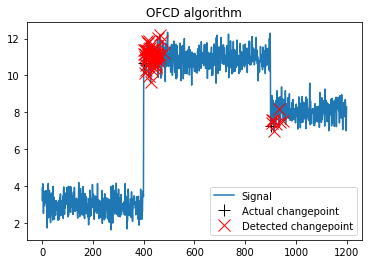

In [6]:
_, ax1 = plt.subplots()
ax1.set_title('OFCD algorithm')
ax1.plot(X)
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12)
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12)
ax1.legend(['Signal','Actual changepoint','Detected changepoint']);

That are definitely too many changepoints. Let's remove some of them with a "min_size" and let's plot the result again:

In [7]:
min_size = 100
my_bkps = my_bkps.flatten()
i = 0
while i < my_bkps.size - 1:
    # if next point is out of defined range it stays in list
    if my_bkps[i+1] > my_bkps[i] + min_size:
        i = i + 1
    # o.w. remove (delete) next point
    else:
        my_bkps = np.delete(my_bkps, i + 1)
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[402 904]


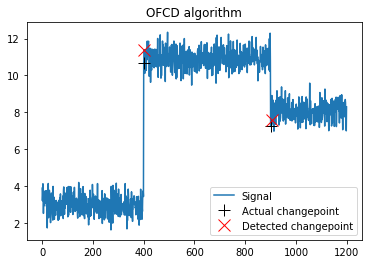

In [8]:
_, ax1 = plt.subplots()
ax1.set_title('OFCD algorithm')
ax1.plot(X)
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12)
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12)
ax1.legend(['Signal','Actual changepoint','Detected changepoint']);

That looks quite accurate. Note, that the input parameters can be adjusted for different signals. Adjusting the input parameters may yield slightly different changepoints.

## 4) Discussion

To our knowledge the OFCD algorithm is the fastest algorithm to detect a changepoint. We also explained that it only works for abrut changes in mean. 

Also, the algorithm has a forgetting factor in the sense that the past can be forgotten. That means, the information from the past of the signal does not affect the algorithm after a changepoint is detected.

## 5) Literature

- Fathy, Yasmin, Payam Barnaghi, and Rahim Tafazolli. "An Online Adaptive Algorithm for Change Detection in Streaming Sensory Data." IEEE Systems Journal 13.3 (2018): 2688-2699.